In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import lightgbm as lgb
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [134]:
df = pd.read_csv("Data/Boston.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df = pd.get_dummies(df, columns=['rad'], dtype='float')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
target = df['medv']
y = df['medv']

X = df.drop(['medv'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# LightGBM

In [136]:
model = LGBMRegressor(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='rmse'
)

In [137]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 1.78161	valid_1's rmse: 3.32032
Early stopping, best iteration is:
[90]	training's rmse: 1.88619	valid_1's rmse: 3.30426


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='rmse',
              num_iterations=10000, num_leaves=10, subsample=0.5, verbosity=-1)

In [138]:
predicciones = model.predict(X_test)
r2_score(y_pred=predicciones, y_true=y_test)

0.853473921052116

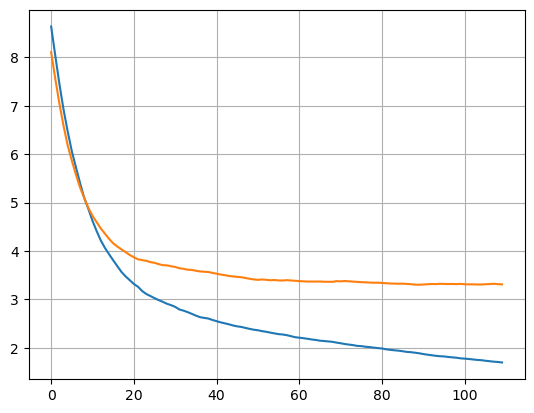

In [139]:
model.evals_result_.keys()

train_loss = model.evals_result_['training']['rmse']
test_loss = model.evals_result_['valid_1']['rmse']

plt.plot(train_loss, label='Train')
plt.plot(test_loss, label= 'Test')
plt.grid()

# Split

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

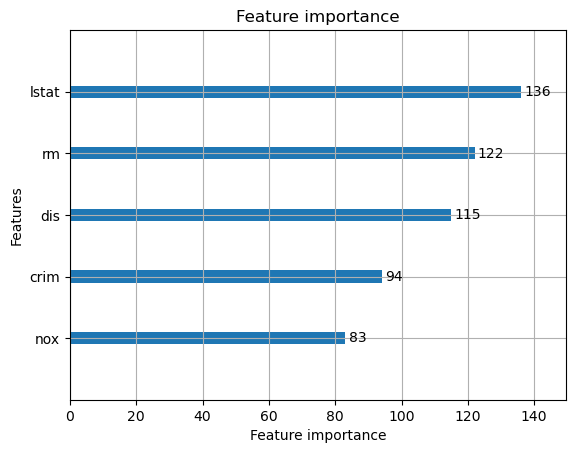

In [140]:
lgb.plot_importance(model, max_num_features=10, importance_type='split')

# Gain

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

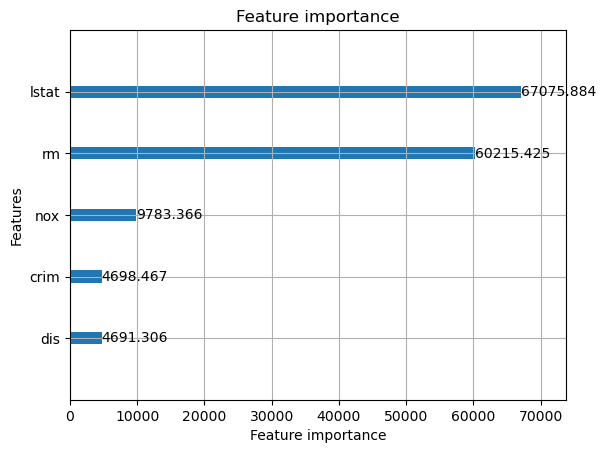

In [141]:
lgb.plot_importance(model, max_num_features=5, importance_type='gain')

# CatBoost

In [142]:
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]
for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

model = CatBoostRegressor(
    iterations=10000,          
    depth=5,                
    learning_rate=0.5,
    subsample=0.25,            
    rsm=0.8,                    
    eval_metric='R2',           
    l2_leaf_reg=0.1,            
    random_strength=5,         
    verbose=100,
    early_stopping_rounds=20    
)

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

# Paso 6: Evaluar
y_pred = model.predict(X_test)
print(f" R²: {r2_score(y_test, y_pred):.4f}")

0:	learn: 0.4459676	test: 0.3567141	best: 0.3567141 (0)	total: 1.72ms	remaining: 17.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8393497203
bestIteration = 30

Shrink model to first 31 iterations.
 R²: 0.8393


In [143]:
df_importances = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

df_importances

,feature,importance
10,lstat,34.728328
5,rm,25.057662
9,ptratio,9.801294
6,age,8.499510
7,dis,4.901025
2,indus,3.229454
3,chas,3.044370
4,nox,2.973015
1,zn,2.953656
0,crim,2.489029


# XGBoost

In [144]:
X_train = X_train.copy().astype('float')
X_test = X_test.copy().astype('float')
y_train = y_train.copy().astype('float')
y_test = y_test.copy().astype('float')

model = XGBRegressor(
    n_estimators=10000,
    max_depth=5,
    learning_rate = 0.1,
    reg_lambda=0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method='hist'
)

# Haz fit, usa early stopping, verboso y evalset [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose=100)

[17:20:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "col_sample_by_tree" } are not used.

[0]	validation_0-rmse:22.04219	validation_1-rmse:20.43246


[100]	validation_0-rmse:0.77894	validation_1-rmse:2.82191
[147]	validation_0-rmse:0.50819	validation_1-rmse:2.82194


/opt/anaconda3/lib/python3.12/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             col_sample_by_tree=0.8, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [145]:
y_pred = model.predict(X_test)
print(f" R²: {r2_score(y_test, y_pred):.4f}")

 R²: 0.8944


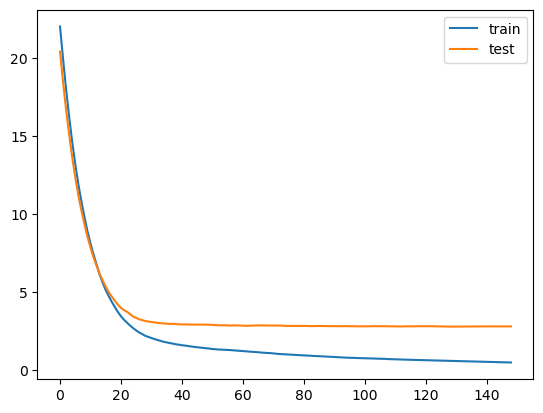

In [146]:
eval_model = model.evals_result()
train_loss = eval_model['validation_0']['rmse']
test_loss = eval_model['validation_1']['rmse']

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()

In [147]:
importancias = model.feature_importances_

df_importancias = pd.DataFrame({
    'features': X_test.keys(),
    'importancias': importancias
})
df_importancias = df_importancias.sort_values('importancias', ascending=False)
df_importancias

,features,importancias
10,lstat,0.313628
5,rm,0.187465
9,ptratio,0.073888
4,nox,0.056190
7,dis,0.054166
3,chas,0.048815
8,tax,0.041568
11,rad_1,0.040149
18,rad_8,0.028481
6,age,0.024583


# Weight

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

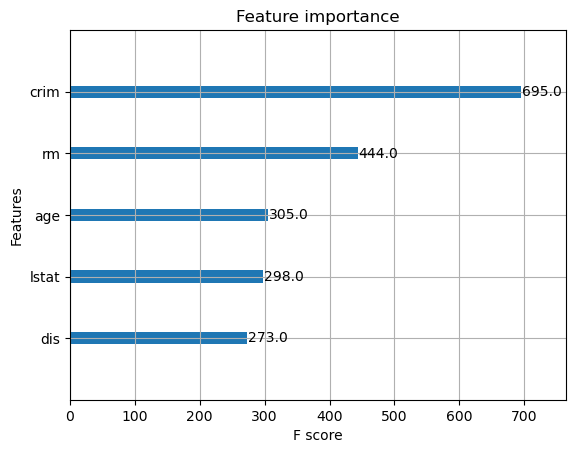

In [148]:
from xgboost import plot_importance

plot_importance(model, max_num_features=5, importance_type='weight')

# Gain

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

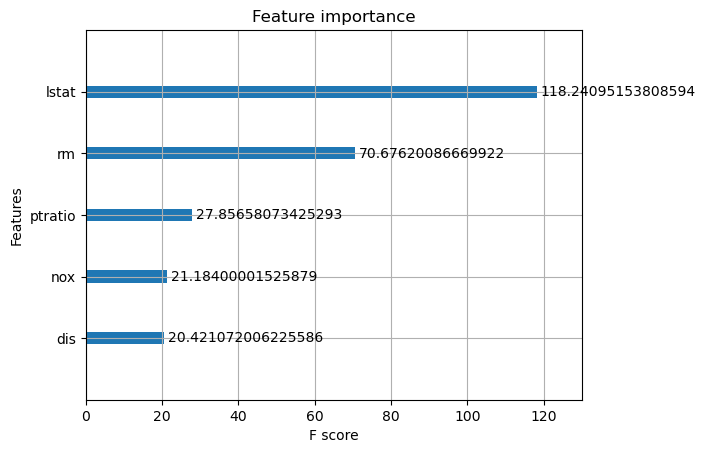

In [149]:
plot_importance(model, max_num_features=5, importance_type='gain')

# Conclusiones

Al aplicar LightGBM, CatBoost y XGBoost al dataset de Boston utilizado en el primer examen y calcular los r2 de cada uno de estos modelos nos damos cuenta que con LightGBM el r2 obtenido es de 0.8790 en este modelo al hacer feature importance con split vemos que lstat, rm y dis son las variables que el modelo utiliza más al mometo de hacer los arboles, pero lstat y rm son las variables que mejor funcionan a la hora de disminuir el error del modelo cada vez que son utilizadas, despues se uso Catboost donde el r2 resulto de 0.8393, vemos una diferencia bastante grande entre un modelo y el otro las variables con mayor importancia e este modelo fueron lstat y rm.

Por último se aplico XGBoost dando en el r2 mas alto 0.8944, a variable mas utilizada en este modelo fue crim aunque la variable que ayudo mas a la disminucion del error en este modelo fue la de lstat, utilizando el dataset del primer examen, el mejor modelo de estos tres fue el de XGBoost seguido por el LightGBM y por ultimo el Catboost